# Step 1: Offline Baseline – Isolation Forest

In this notebook, we apply the Isolation Forest algorithm to the time series datasets generated earlier (Normality 1–3) in a fully offline setting. The full dataset is provided to the model at once, simulating scenarios without real-time constraints.

We use synthetic labels for evaluation and measure the model’s precision, recall, and F1-score.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from matplotlib.collections import LineCollection
import warnings

# Set paths
DATA_DIR = "generated_datasets"
PLOTS_PATH = "results_offline_iforest"
RESULTS_DIR = "results_streaming"
CONTAMINATION = 0.1  # Assumed anomaly rate

os.makedirs(RESULTS_DIR, exist_ok=True)


## Load Datasets

We iterate through all `.npy` files (excluding `_boundaries.npy`) in the `generated_datasets/` folder. Each dataset contains a normalized, concatenated time series.


In [2]:
def load_dataset(file):
    """Loads the time series data from a .npy file"""
    return np.load(os.path.join(DATA_DIR, file))

## Generate Synthetic Anomaly Labels

Because we do not yet have true ground truth labels, we simulate them by assuming that the last 5% of the data points are anomalous.


In [38]:
def generate_synthetic_labels(length, contamination=CONTAMINATION):
    """Simulate labels by assuming the last X% of points are anomalies"""
    n_anomalies = int(length * contamination)
    labels = np.zeros(length)
    labels[-n_anomalies:] = 1  # anomalies at the end
    return labels

## Run Isolation Forest

We fit the Isolation Forest model on the full dataset and evaluate its performance using synthetic labels.


In [3]:
def run_isolation_forest(data, contamination=CONTAMINATION):
    """Applies Isolation Forest and returns predictions + anomaly scores"""
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(data)
    scores = model.decision_function(data)  # Higher = more normal
    preds = model.predict(data)
    preds_binary = np.where(preds == -1, 1, 0)  # Convert to 1=anomaly
    return preds_binary, scores


In [4]:
def evaluate(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, -scores) if scores is not None else None  # Invert scores if higher = more normal
    return precision, recall, f1, auc

In [5]:
def colored_line_between_pts(x, y, c, ax, **lc_kwargs):
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    if len(c) != len(x) - 1:
        warnings.warn(
            "The c argument should have a length one less than the length of x and y. "
            "If it has the same length, use the colored_line function instead."
        )

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, **lc_kwargs)
    lc.set_array(c)
    return ax.add_collection(lc)


def plot_results(data, scores, preds, title, custom_cmap, save_path=None, show=True):
    data = data.flatten()
    preds = preds.flatten()
    x = np.arange(len(data))
    y = data

    # Use midpoints of prediction values for coloring (one less than data points)
    c = preds[:-1]

    fig, ax = plt.subplots(figsize=(14, 5))
    plt.style.use("seaborn-v0_8-muted")

    # Plot main colored time series
    colored_line_between_pts(x, y, c, ax, linewidth=2, cmap=custom_cmap)  # blue=normal, red=anomaly

    # Overlay anomaly score as a line
    ax.plot(scores, label="Anomaly Score", color="orange", linewidth=1, alpha=0.7)

    # Legend and labels
    legend_handles = [
        plt.Line2D([0], [0], color="#2c7bb6", lw=2, label="Normal"),
        plt.Line2D([0], [0], color="#d7191c", lw=2, label="Anomaly"),
        plt.Line2D([0], [0], color="orange", lw=2, label="Anomaly Score")
    ]
    ax.legend(handles=legend_handles)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min() - 0.1, y.max() + 0.1)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close()

## Run Model on All Datasets

We now process every Normality dataset (excluding the `_boundaries.npy` files), run the model, evaluate, and save a plot and performance metrics.


Processing: normality_1_daphnet.npy


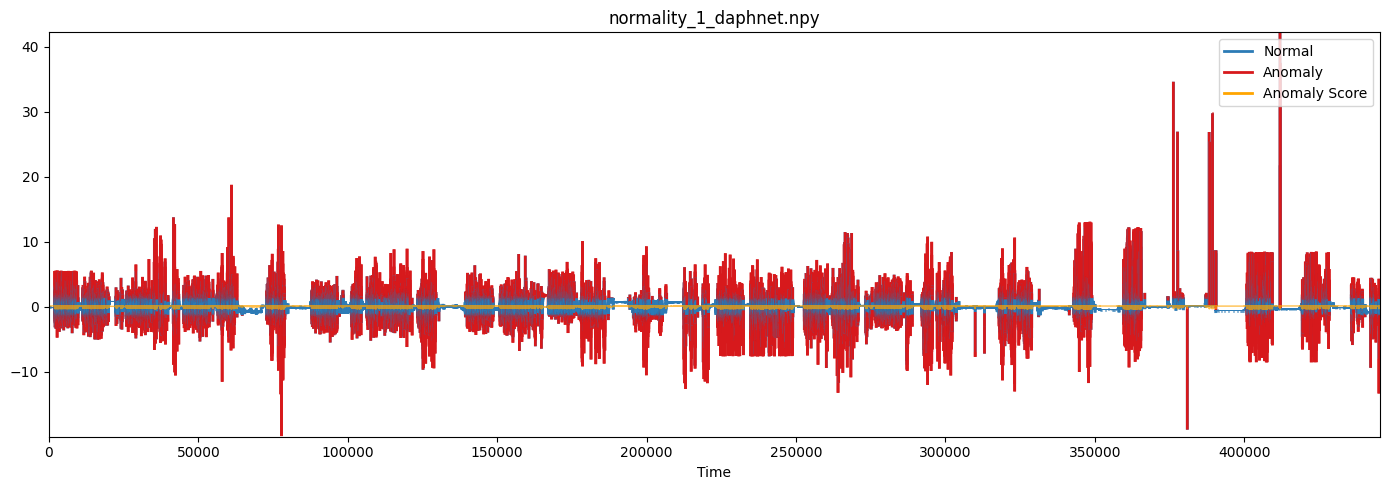

Processing: normality_1_genesis.npy


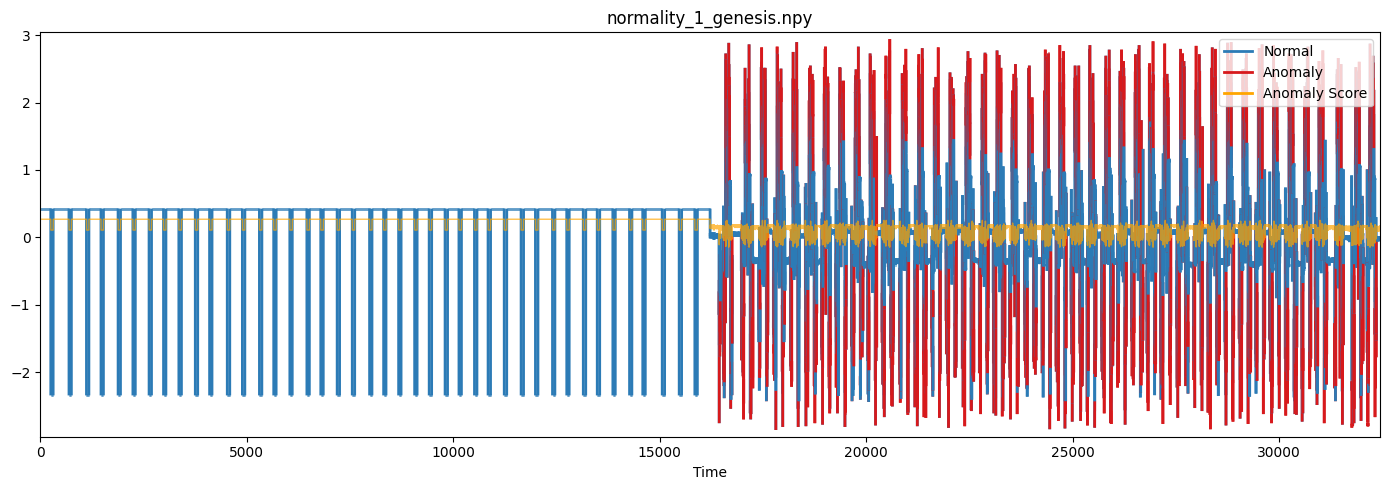

Processing: normality_1_nasa-msl.npy


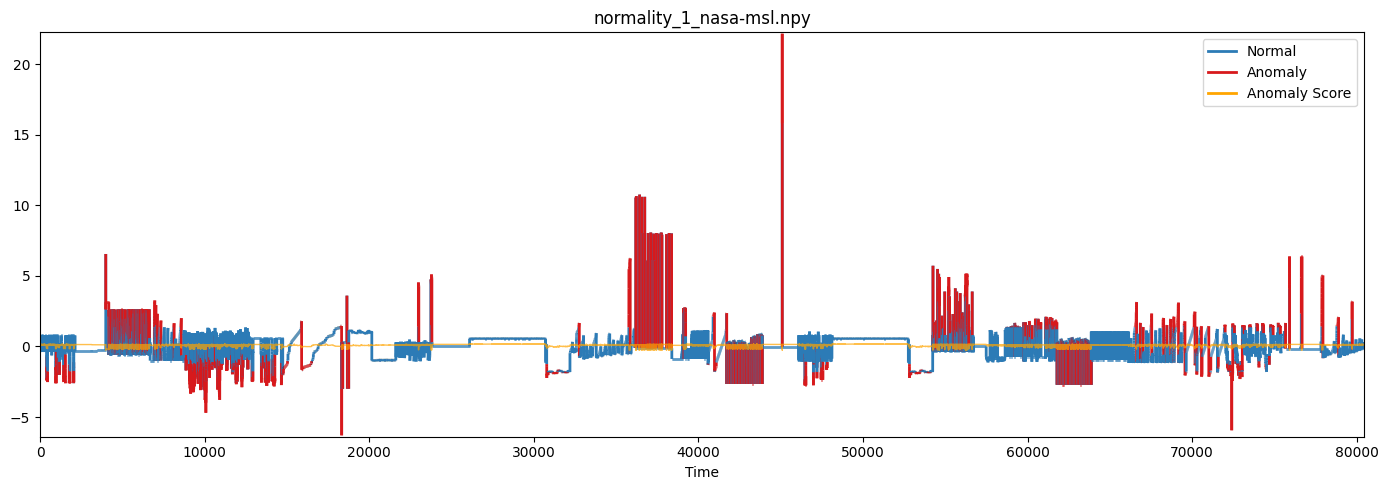

Processing: normality_2_1_daphnet_genesis.npy


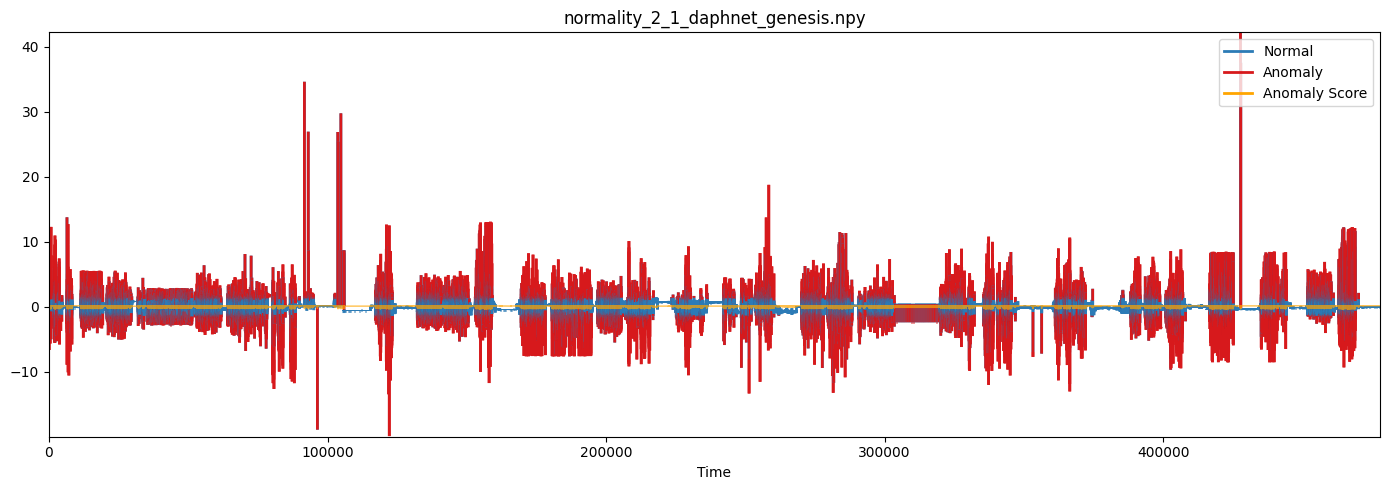

Processing: normality_2_2_daphnet_nasa-msl.npy


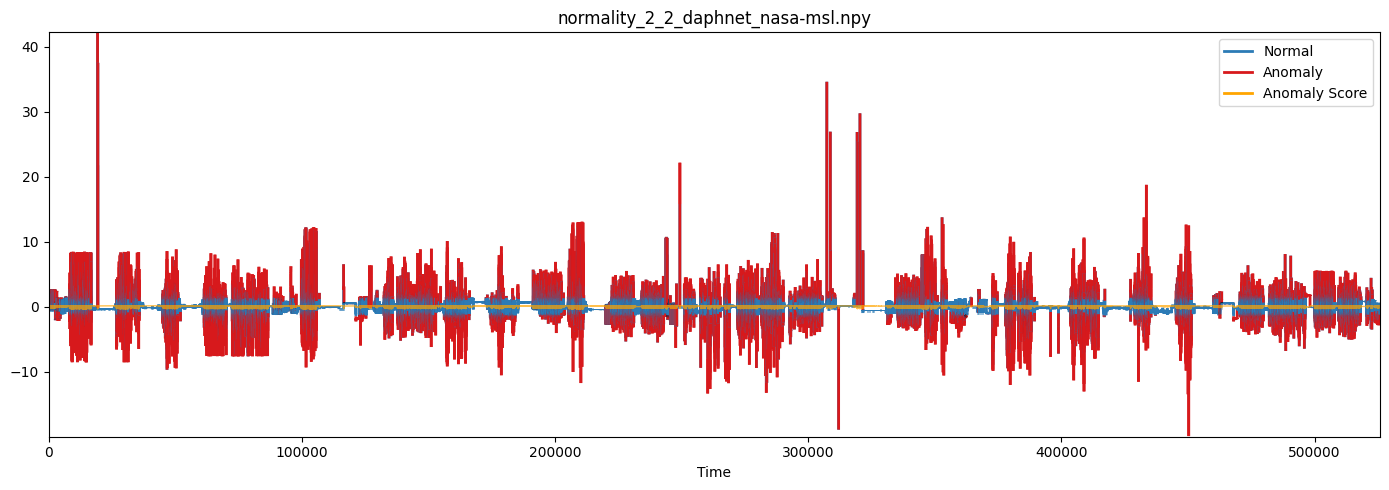

Processing: normality_2_3_genesis_nasa-msl.npy


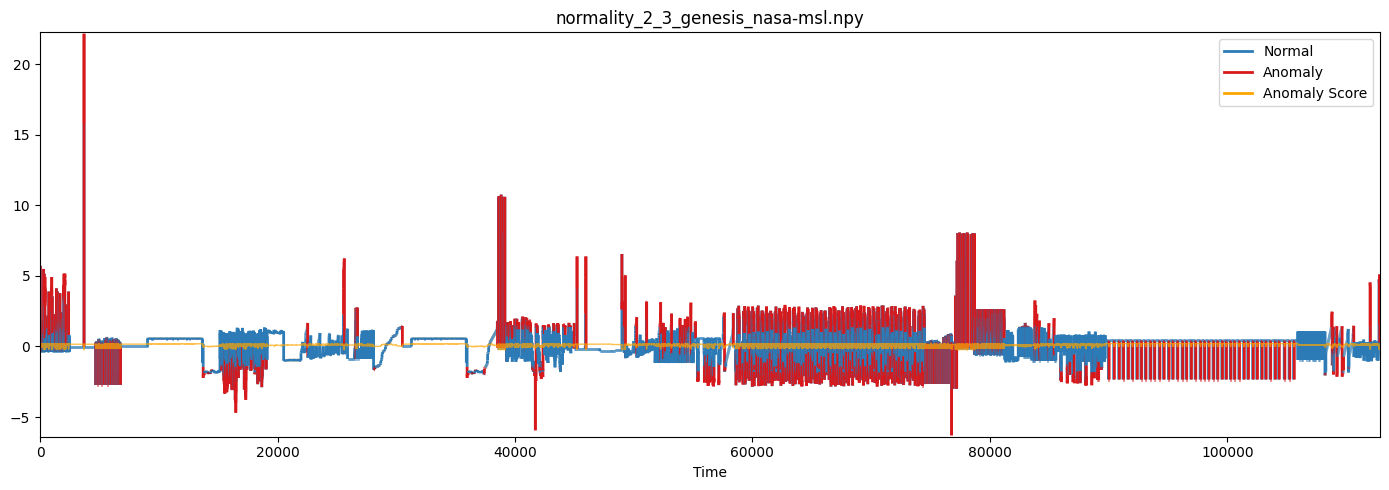

Processing: normality_3_1_daphnet_genesis_nasa-msl.npy


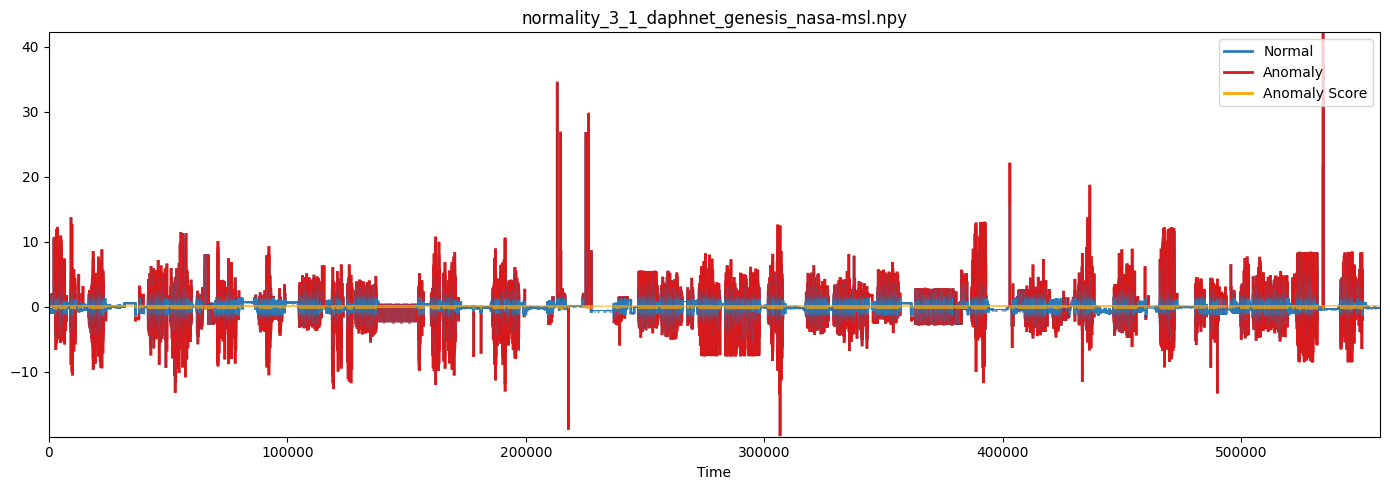

Processing: normality_3_2_genesis_nasa-msl_daphnet.npy


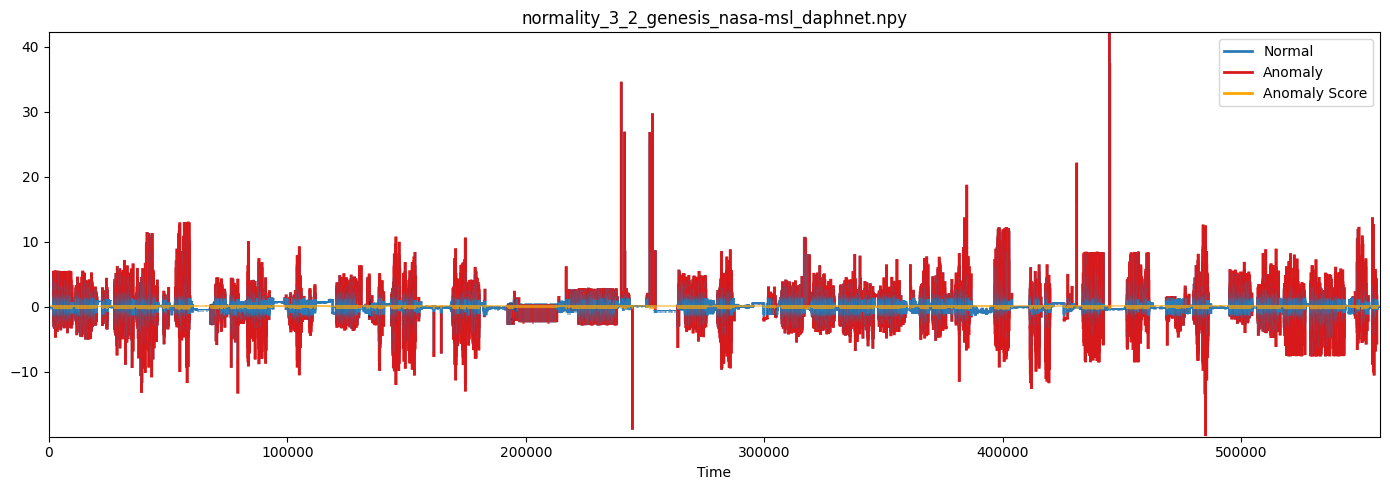

Processing: normality_3_3_nasa-msl_daphnet_genesis.npy


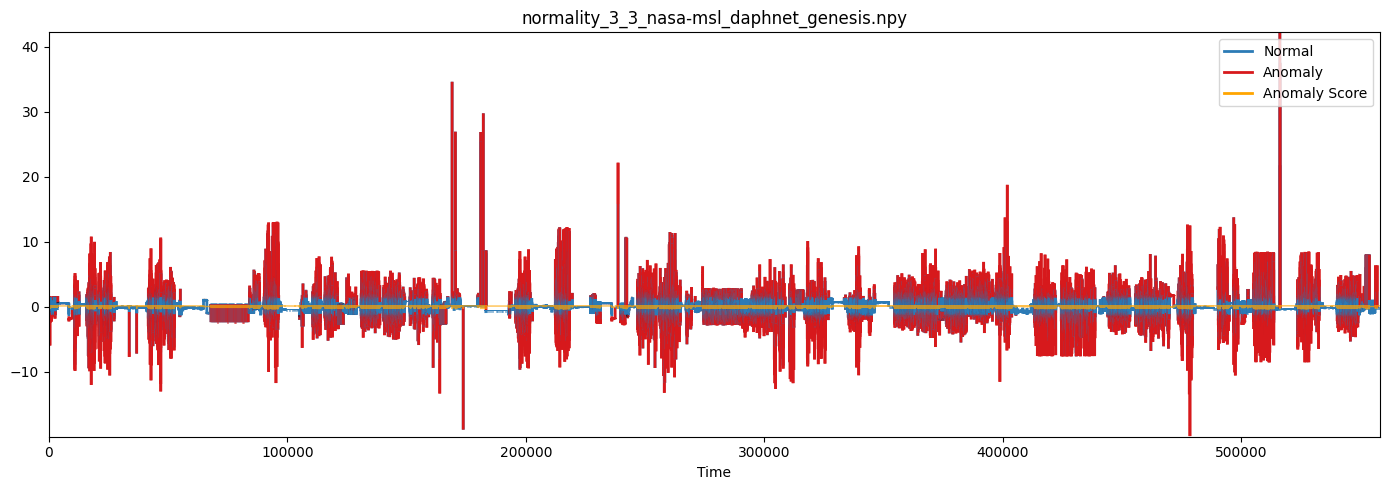


 Summary of All Offline Results:


,length,precision,recall,f1_score,auc
dataset,,,,,
normality_1_daphnet.npy,445440,0.224,0.196,0.209,0.601
normality_1_genesis.npy,32440,0.014,0.450,0.027,0.594
normality_1_nasa-msl.npy,80427,0.139,0.226,0.172,0.648
normality_2_1_daphnet_genesis.npy,477880,0.199,0.187,0.193,0.602
normality_2_2_daphnet_nasa-msl.npy,525867,0.205,0.194,0.199,0.605
normality_2_3_genesis_nasa-msl.npy,112867,0.098,0.220,0.136,0.673
normality_3_1_daphnet_genesis_nasa-msl.npy,558307,0.188,0.188,0.188,0.599
normality_3_2_genesis_nasa-msl_daphnet.npy,558307,0.188,0.188,0.188,0.602
normality_3_3_nasa-msl_daphnet_genesis.npy,558307,0.187,0.187,0.187,0.598


In [6]:
results = []
custom_cmap = ListedColormap(["#2c7bb6", "#d7191c"])  # blue, red

for filename in os.listdir(DATA_DIR):
    if filename.endswith(".npy") and "_boundaries" not in filename and "_labels" not in filename:
        print(f"Processing: {filename}")
        data = load_dataset(filename).reshape(-1, 1)
        # Construct the expected labels filename
        label_filename = filename.replace(".npy", "_labels.npy")
        label_path = os.path.join(DATA_DIR, label_filename)
        
        if os.path.exists(label_path):
            labels = load_dataset(label_filename).reshape(-1, 1)
        else:
            raise FileNotFoundError(f"Labels file not found for {filename}")

        preds, scores = run_isolation_forest(data, CONTAMINATION)
        precision, recall, f1 ,auc = evaluate(labels, preds)

        # Plot inline AND save
        plot_file = os.path.join(PLOTS_PATH, filename.replace(".npy", ".png"))
        plot_results(data, scores, preds, title=filename, custom_cmap=custom_cmap, save_path=plot_file)

        results.append({
            "dataset": filename,
            "length": len(data),
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1_score": round(f1, 3),
            "auc": round(auc, 3)
        })

    

# Save results to CSV
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="dataset")
results_df.set_index("dataset", inplace=True)

print("\n Summary of All Offline Results:")
display(results_df)

# Save to CSV as before
results_df.to_csv(os.path.join(RESULTS_DIR, "offline_iforest_results.csv"))

## Summary

We applied Isolation Forest to each dataset in an offline setting. Real labels from TSB-UAD are used to track the performance of Isolation Forest as a baseline method.

Next, we will evaluate a real-time method like SAND to see how it performs under streaming conditions.
